In [1]:
import random
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib as mpl
mpl.style.use('classic')

In [2]:
random_state = 0
random.seed(random_state)
np.random.seed(random_state)
torch.random.manual_seed(random_state)

In [3]:
class Derivative:
    def __init__(self, name, payoff_fun, bid, ask, info):
        self.name = name
        self.payoff_fun = payoff_fun
        self.deribit_info = info
        self.bid = bid
        self.ask = ask

In [4]:
def retrieve_instruments(currency, expired=False):
    assert currency in ["ETH", "SOL", "BTC"]
    expired = "true" if expired else "false"
    instruments = requests.get(
        "https://deribit.com/api/v2/public/get_book_summary_by_currency?currency={}&kind=option".format(currency)
    ).json()["result"]
    return instruments

currency = 'ETH'
instruments = retrieve_instruments(currency=currency)
print('Total of {} instruments for {} available on Deribit'.format(len(instruments), currency))

Total of 686 instruments for ETH available on Deribit


In [5]:
# df_instrument = pd.read_csv('./data/deribit_instruments.csv', index_col=[0])
df_instrument = pd.DataFrame(instruments)
df_instrument[['currency', 'expire_date', 'strike_price', 'option_type']] = df_instrument.instrument_name.str.split('-', expand=True)
df_instrument

,mid_price,estimated_delivery_price,volume_usd,quote_currency,creation_timestamp,base_currency,interest_rate,volume,underlying_index,underlying_price,...,ask_price,bid_price,instrument_name,last,low,high,currency,expire_date,strike_price,option_type
0,0.0008,2251.45,154.07,ETH,1704616110384,ETH,0.0,61.0,ETH-26JAN24,2271.670000,...,0.0009,0.0007,ETH-26JAN24-1200-P,0.0011,0.0008,0.0012,ETH,26JAN24,1200,P
1,NaN,2251.45,0.00,ETH,1704616110384,ETH,0.0,0.0,ETH-12JAN24,2255.130000,...,NaN,NaN,ETH-12JAN24-2550-P,0.0755,NaN,NaN,ETH,12JAN24,2550,P
2,0.0365,2251.45,2712.81,ETH,1704616110384,ETH,0.0,36.0,ETH-23FEB24,2296.990000,...,0.0370,0.0360,ETH-23FEB24-2800-C,0.0360,0.0330,0.0360,ETH,23FEB24,2800,C
3,NaN,2251.45,0.00,ETH,1704616110384,ETH,0.0,0.0,SYN.ETH-10JAN24,2253.672233,...,NaN,NaN,ETH-10JAN24-1950-C,NaN,NaN,NaN,ETH,10JAN24,1950,C
4,0.1735,2251.45,224419.09,ETH,1704616110384,ETH,0.0,500.0,ETH-29MAR24,2322.010000,...,0.2900,0.0570,ETH-29MAR24-2000-C,0.1995,0.1995,0.2010,ETH,29MAR24,2000,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,NaN,2251.45,0.00,ETH,1704616110397,ETH,0.0,0.0,SYN.ETH-9JAN24,2252.943350,...,NaN,NaN,ETH-9JAN24-2850-P,NaN,NaN,NaN,ETH,9JAN24,2850,P
682,NaN,2251.45,0.00,ETH,1704616110397,ETH,0.0,0.0,SYN.ETH-8JAN24,2252.214467,...,NaN,NaN,ETH-8JAN24-2800-P,NaN,NaN,NaN,ETH,8JAN24,2800,P
683,NaN,2251.45,0.00,ETH,1704616110397,ETH,0.0,0.0,ETH-23FEB24,2296.990000,...,NaN,NaN,ETH-23FEB24-1300-C,NaN,NaN,NaN,ETH,23FEB24,1300,C
684,NaN,2251.45,0.00,ETH,1704616110397,ETH,0.0,0.0,ETH-27DEC24,2503.300000,...,NaN,NaN,ETH-27DEC24-7500-P,NaN,NaN,NaN,ETH,27DEC24,7500,P


In [6]:
upper = 5
sample = 100

In [7]:
p0 = df_instrument.estimated_delivery_price.mean()
x = np.linspace(0, upper, sample)
x_list = []

for i in df_instrument.index:
    c = float(df_instrument.iloc[i]['ask_price'] * p0)
    k = float(df_instrument.iloc[i]['strike_price'])
    if df_instrument.iloc[i]['option_type'] == 'C':
        yl = (np.maximum(0, x * p0 - k) - c) / p0
        # ys = (c - np.maximum(0, x * p0 - k)) / p0
    else:
        yl = (np.maximum(0, k - x * p0) - c) / p0
        # ys = (c - np.maximum(0, k - x * p0)) / p0
    x_list.append(yl)
    # x_list.append(ys)

In [8]:
x = np.linspace(0, upper, sample)
y = 2 * np.sqrt(x) / (x + 1) - 1
print(-y)

[1.00000000e+00 5.72142395e-01 4.22674029e-01 3.23935127e-01
 2.52148052e-01 1.97590777e-01 1.55074320e-01 1.21429095e-01
 9.45535124e-02 7.29751891e-02 5.56209880e-02 4.16851525e-02
 3.05484846e-02 2.17261983e-02 1.48328810e-02 9.55816439e-03
 5.64936486e-03 2.89881404e-03 1.13443031e-03 2.12585036e-04
 1.26260235e-05 4.32619531e-04 1.38600205e-03 2.79892091e-03
 4.60810276e-03 6.75913119e-03 9.20504448e-03 1.19051863e-02
 1.48242576e-02 1.79315304e-02 2.12001922e-02 2.46067958e-02
 2.81307971e-02 3.17541634e-02 3.54610419e-02 3.92374758e-02
 4.30711630e-02 4.69512477e-02 5.08681425e-02 5.48133733e-02
 5.87794462e-02 6.27597313e-02 6.67483619e-02 7.07401466e-02
 7.47304921e-02 7.87153360e-02 8.26910877e-02 8.66545759e-02
 9.06030033e-02 9.45339056e-02 9.84451162e-02 1.02334734e-01
 1.06201095e-01 1.10042748e-01 1.13858433e-01 1.17647059e-01
 1.21407688e-01 1.25139520e-01 1.28841877e-01 1.32514191e-01
 1.36155993e-01 1.39766904e-01 1.43346622e-01 1.46894919e-01
 1.50411629e-01 1.538966

In [9]:
mat_X = np.array(x_list)
mat_X = mat_X[~np.isnan(mat_X).any(axis=1)]  # remove options with nan payoff
mat_X = np.unique(mat_X, axis=0)  # remove duplicates
mat_X

array([[-0.6       , -0.6       , -0.6       , ...,  3.58833676,
         3.63884181,  3.68934687],
       [-0.49      , -0.49      , -0.49      , ...,  3.60950512,
         3.66001017,  3.71051522],
       [-0.44      , -0.44      , -0.44      , ...,  3.74833676,
         3.79884181,  3.84934687],
       ...,
       [ 0.99085597,  0.94035092,  0.88984587, ..., -0.0085    ,
        -0.0085    , -0.0085    ],
       [ 0.99545993,  0.94495488,  0.89444982, ..., -0.015     ,
        -0.015     , -0.015     ],
       [ 0.99727179,  0.94676674,  0.89626169, ..., -0.0465    ,
        -0.0465    , -0.0465    ]])

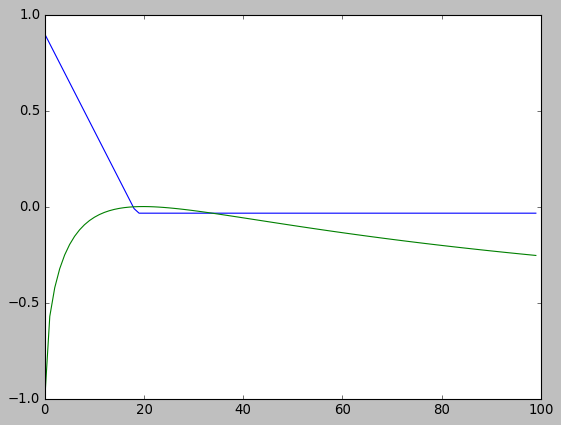

In [10]:
plt.plot(mat_X[350])
plt.plot(y)

In [11]:
X = torch.from_numpy(mat_X.transpose())
Y = torch.from_numpy(-y)
X = X.float()
Y = Y.float()

In [12]:
# Define a linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, 1)  # One output for regression

    def forward(self, x):
        return self.linear(x)

# Instantiate the model
input_size = X.shape[1]
model = LinearRegressionModel(input_size)

# Define the loss function (Mean Squared Error)
criterion = nn.MSELoss()

# Define the optimizer (Stochastic Gradient Descent)
optimizer = optim.SGD(model.parameters(), lr=0.0001)

In [13]:
epoch_loss = 0

progress = tqdm(range(5000))

for epoch in progress:
    epoch_loss = 0
    optimizer.zero_grad()
    for i in range(int(sample / upper * 3)):
        predictions = model(X[i])

        mse_loss = criterion(predictions, Y[i])
        l2_reg = sum(p.pow(2.0).sum() for p in model.parameters()) * 0.01
        loss = mse_loss + l2_reg
        
        epoch_loss += loss.item()
        # # Backward pass and optimization
        # optimizer.zero_grad()
        loss.backward()
    
    optimizer.step()
    
    progress.set_postfix_str(round(epoch_loss, 4))
    
    # print(epoch_loss)

  0%|          | 0/5000 [00:00<?, ?it/s]/Users/chengjiaxiang/opt/anaconda3/envs/survml/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|██████████| 5000/5000 [01:48<00:00, 46.11it/s, 0.2301]


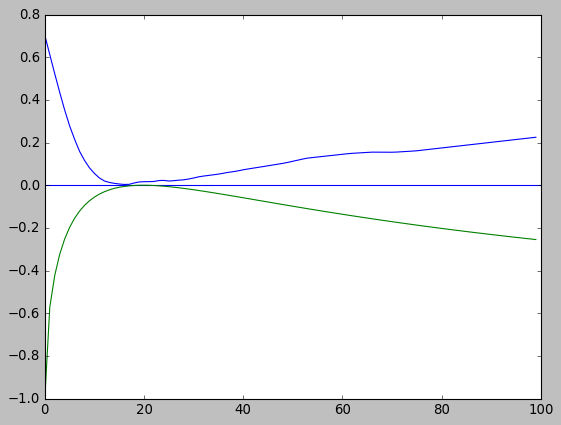

In [14]:
w = model.linear.weight.data.numpy()
plt.plot(np.matmul(mat_X.transpose(), w.transpose()))
plt.axhline()
plt.plot(y)

/var/folders/s0/gcg7k5ws6hxfgnzww6_ryn0c0000gn/T/ipykernel_23651/155089572.py:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
/var/folders/s0/gcg7k5ws6hxfgnzww6_ryn0c0000gn/T/ipykernel_23651/155089572.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])


Text(0.5, 0, 'Current Price as Percentage of Initial Price')

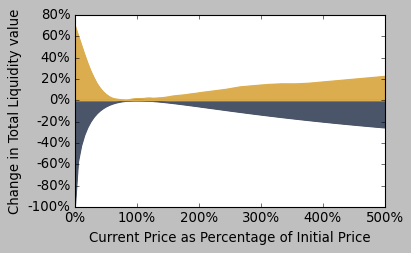

In [17]:
f = plt.figure(figsize=(5,3))
# Setting the background color of the plot 
ax = plt.axes()
# ax.set_facecolor("#F0EEDC")

x = np.linspace(0, upper, sample)
y = 2 * np.sqrt(x) / (x + 1) - 1
h = np.matmul(mat_X.transpose(), np.array(w).transpose())

plt.plot(x, y, color='#4B5569')
plt.axhline(color='#4B5569')

plt.plot(x, h, color='#DBAD4F')
plt.axhline(color='#DBAD4F')

# ax.set_ylim(-1.05, 0.75)
plt.xlim(0, upper)

ax.fill_between(x, 0, y, color='#4B5569')
ax.fill_between(x, 0, h.transpose().tolist()[0], color='#DBAD4F')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge.png', dpi=500, bbox_inches='tight', transparent=True)

/var/folders/s0/gcg7k5ws6hxfgnzww6_ryn0c0000gn/T/ipykernel_23651/393944969.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
/var/folders/s0/gcg7k5ws6hxfgnzww6_ryn0c0000gn/T/ipykernel_23651/393944969.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])


Text(0.5, 0, 'Current Price as Percentage of Initial Price')

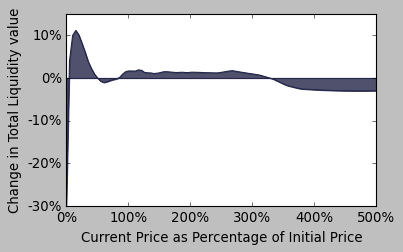

In [18]:
f = plt.figure(figsize=(5,3))
# Setting the background color of the plot 
ax = plt.axes()
# ax.set_facecolor("#F0EEDC")

x = np.linspace(0, upper, sample)
y = 2 * np.sqrt(x) / (x + 1) - 1
h = np.matmul(mat_X.transpose(), np.array(w).transpose())

plt.plot(x, h.transpose().tolist()[0] + y, color='#242749')
plt.axhline(color='#242749')

# ax.set_ylim(-0.45, 0.25)
plt.xlim(0, upper)

ax.fill_between(x, 0, h.transpose().tolist()[0] + y, color='#242749', alpha=0.8)
# ax.fill_between(x, 0, h.transpose().tolist()[0], color='#DBAD4F')

plt.rcParams.update({'font.sans-serif':'DejaVu Sans'})

vals_y = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals_y])
vals_x = ax.get_xticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in vals_x])

plt.ylabel('Change in Total Liquidity value')
plt.xlabel('Current Price as Percentage of Initial Price')
# plt.savefig('./img/IL_hedge_loss.png', dpi=500, bbox_inches='tight', transparent=True)